In [1]:
import os
import time

import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
import torchvision.utils as tvutils

import adabound

# import cv2
# import PIL
# import matplotlib.pyplot as plt

from my_utils import data, models
from my_utils.utils import save_model, check_accuracy, trainer, train_a_model
from my_utils.vis import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)  # set default size of plots

# life save magic code
%load_ext autoreload
%autoreload 2

In [2]:
print(f"torch version: {torch.__version__}")
use_cuda = torch.cuda.is_available()
if use_cuda:
    GPU_nums = torch.cuda.device_count()
    GPU = torch.cuda.get_device_properties(0)
    print(f"There are {GPU_nums} GPUs in total.\nThe first GPU is: {GPU}")
    if '3060' in GPU.name:
        print(f"CUDA version: {torch.cuda_version}")
    else:
        print(f"CUDA version: {torch.version.cuda}")
device = torch.device(f"cuda:{GPU_nums - 1}" if use_cuda else "cpu")
print(f"Using {device} now!")

torch version: 1.10.2
There are 8 GPUs in total.
The first GPU is: _CudaDeviceProperties(name='Tesla V100-SXM2-32GB', major=7, minor=0, total_memory=32510MB, multi_processor_count=80)
CUDA version: 11.3
Using cuda:7 now!


In [3]:
batch_size = 256
fig_resize = 32
mean, std = torch.tensor(0.2036), torch.tensor(0.4027)
T = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((fig_resize, fig_resize)),
    transforms.Normalize(mean, std)
])
loader_kwargs = {
    'batch_size': batch_size,   # default:1
    'shuffle': True,            # default:False
    'num_workers': 4,           # default:0
    'pin_memory': True,         # default:False
    'drop_last': True,          # default:False
    'prefetch_factor': 4,       # default:2
    'persistent_workers': False # default:False
}

In [4]:
# 制作二进制数据集
Dataset_DIR = '/home/wangyh/01-Projects/03-my/Datasets/polygons_unfilled_32_2'

train_data = data.MyDataset(os.path.join(Dataset_DIR, 'train'), transform=T)
train_loader = DataLoader(train_data, **loader_kwargs)

val_data = data.MyDataset(os.path.join(Dataset_DIR, 'val'), transform=T)
val_loader = DataLoader(val_data, **loader_kwargs)

test_data = data.MyDataset(os.path.join(Dataset_DIR, 'test'), transform=T)
test_loader = DataLoader(test_data, **loader_kwargs)

In [5]:
sample_step = 10

small_train_data = Subset(train_data, torch.arange(0, len(train_data) - 1, sample_step))
small_train_loader = DataLoader(small_train_data, **loader_kwargs)

small_val_data = Subset(val_data, torch.arange(0, len(val_data) - 1, sample_step))
small_val_loader = DataLoader(small_val_data, **loader_kwargs)

In [6]:
# check data before training!
img, label = train_data[0]
print(len(train_data), '\t', img.shape)
imgs, labels = next(iter(train_loader))
print(len(train_loader), '\t', imgs.shape)

img, label = val_data[0]
print(len(val_data), '\t', img.shape)
imgs, labels = next(iter(val_loader))
print(len(val_loader), '\t', imgs.shape)

40000 	 torch.Size([1, 32, 32])
156 	 torch.Size([256, 1, 32, 32])
8000 	 torch.Size([1, 32, 32])
31 	 torch.Size([256, 1, 32, 32])


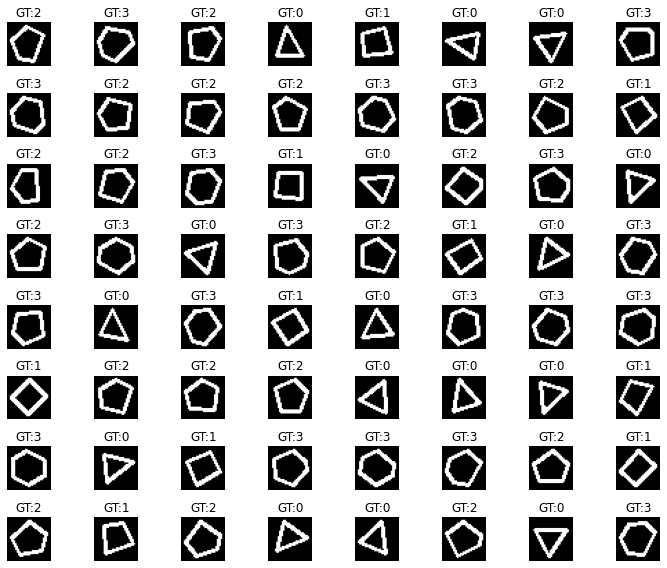

In [7]:
grid_vis(test_loader, 8)

In [33]:
# model = models.simple_Conv(in_chans=1, num_classes=4, depths=(2, 2, 2) ).to(device)
model = models.simple_Conv().to(device)
# optimizer = adabound.AdaBound(model.parameters(), lr=1e-4, final_lr=0.1)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.05)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.05)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
loss_func = nn.CrossEntropyLoss()
print("Using device:", next(model.parameters()).device)
print(model)

Using device: cuda:7
simple_Conv(
  (stages): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu-4): ReLU()
    )
    (1): Sequential()
    (2): Sequential(
      (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu-8): ReLU()
    )
    (3): Sequential()
    (4): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu-16): ReLU()
    )
  )
  (head): Linear(in_features=16, out_features=4, bias=True)
)


In [ ]:
# copy the following line to prompt line!
# tensorboard --logdir runs

In [21]:
# writer = SummaryWriter()
# writer.add_graph(model, torch.rand([1, 1, 32, 32], device=device))

/home/wangyh/01-Projects/03-my/my_utils/models.py:147: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  return self.norm(x) if x.size(0) > 1 else x


In [32]:
writer.close()

In [34]:
# reset train history
batch_step = 0
# writer = SummaryWriter(log_dir='./tblogs', comment="BS_256_WD_0.05")
writer = SummaryWriter(comment="BS_256_OP_SGD0.9_WD_0.05")

In [12]:
# Train and test!
check_loaders = {'train':small_train_loader,
                 'val':small_val_loader}

In [35]:
batch_step = trainer(model, optimizer, None, loss_func, train_loader,
                   check_fn=check_accuracy,
                   check_loaders=check_loaders,
                   batch_step=batch_step, epochs=50, log_every=30, writer=writer)

Epoch: 1 [0/156]	Loss: 1.5052	Val acc: 25.0%
Epoch: 1 [30/156]	Loss: 1.4332	Val acc: 24.1%
Epoch: 1 [60/156]	Loss: 1.4113	Val acc: 24.5%
Epoch: 1 [90/156]	Loss: 1.4256	Val acc: 23.4%
Epoch: 1 [120/156]	Loss: 1.3771	Val acc: 25.0%
Epoch: 1 [150/156]	Loss: 1.3792	Val acc: 26.4%
====> Epoch: 1	Time: 9.525742530822754s
Epoch: 2 [0/156]	Loss: 1.3634	Val acc: 26.3%
Epoch: 2 [30/156]	Loss: 1.3653	Val acc: 25.4%
Epoch: 2 [60/156]	Loss: 1.3650	Val acc: 26.7%
Epoch: 2 [90/156]	Loss: 1.3635	Val acc: 29.0%
Epoch: 2 [120/156]	Loss: 1.3578	Val acc: 33.2%
Epoch: 2 [150/156]	Loss: 1.3585	Val acc: 35.9%
====> Epoch: 2	Time: 9.47299575805664s
Epoch: 3 [0/156]	Loss: 1.3601	Val acc: 36.7%
Epoch: 3 [30/156]	Loss: 1.3591	Val acc: 38.9%
Epoch: 3 [60/156]	Loss: 1.3584	Val acc: 42.8%
Epoch: 3 [90/156]	Loss: 1.3601	Val acc: 46.5%
Epoch: 3 [120/156]	Loss: 1.3516	Val acc: 47.3%
Epoch: 3 [150/156]	Loss: 1.3560	Val acc: 50.3%
====> Epoch: 3	Time: 9.581823587417603s
Epoch: 4 [0/156]	Loss: 1.3536	Val acc: 50.4%
Epoch

Exception ignored in: <function _releaseLock at 0x7f1cac7d10d0>
Traceback (most recent call last):
  File "/home/wangyh/anaconda3/envs/my/lib/python3.9/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


RuntimeError: DataLoader worker (pid(s) 43557) exited unexpectedly

In [28]:
writer.close()

In [23]:
model.eval()
test_acc = check_accuracy(model, test_loader)
print(f'Test accuracy is : {100. * test_acc:.2f}%')

Test accuracy is : 85.95%	Infer time: 0.84413743019104


TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

In [25]:
# Save model
save_model(model, optimizer, model_type='myconvnext', acc=86)

Model parameters:
connection_layers.0.weight:	 torch.Size([4, 1])
connection_layers.0.bias:	 torch.Size([4])
connection_layers.1.weight:	 torch.Size([8, 4])
connection_layers.1.bias:	 torch.Size([8])
connection_layers.2.weight:	 torch.Size([16, 8])
connection_layers.2.bias:	 torch.Size([16])
norm_layers.0.weight:	 torch.Size([4])
norm_layers.0.bias:	 torch.Size([4])
norm_layers.0.running_mean:	 torch.Size([4])
norm_layers.0.running_var:	 torch.Size([4])
norm_layers.0.num_batches_tracked:	 torch.Size([])
norm_layers.1.weight:	 torch.Size([4])
norm_layers.1.bias:	 torch.Size([4])
norm_layers.1.running_mean:	 torch.Size([4])
norm_layers.1.running_var:	 torch.Size([4])
norm_layers.1.num_batches_tracked:	 torch.Size([])
norm_layers.2.weight:	 torch.Size([8])
norm_layers.2.bias:	 torch.Size([8])
norm_layers.2.running_mean:	 torch.Size([8])
norm_layers.2.running_var:	 torch.Size([8])
norm_layers.2.num_batches_tracked:	 torch.Size([])
stages.0.0.gamma:	 torch.Size([4])
stages.0.0.dwconv.weight

In [27]:
# reload modal paras from saved .pt file
new_model = models.my_ConvNeXt()

new_model.to(device)
new_optimizer = torch.optim.Adam(new_model.parameters(), lr=1e-5, weight_decay=0.1)

save_path = 'saved_models/97_polygen_unfilled_myconvnext_2022_01_21_19_58_50.pt'
checkpoint = torch.load(save_path)
new_model.load_state_dict(checkpoint["model_paras"])
new_optimizer.load_state_dict(checkpoint["optim_paras"])

In [28]:
model_configs = {
    'type': 'simple_conv',
    'kernel_size': 5,
    'depths': (1, 2, 1),
    'dims': (4, 8, 16)
}
train_configs = {
    'log_dir': 'newruns',
    'dataset_dir': '/home/wangyh/01-Projects/03-my/Datasets/polygons_unfilled_64_3',
    'batch_size': 512,
    'epochs': 140,
    'device': 'cuda:7',
    'optim': 'AdamW',
    'lr': 1.5e-4,
    'schedule': 'cosine_warm',
    'cos_T': 30,
    'cos_mul': 2,
    'cos_iters': 2,
    'momentum': 0.9,
    'weight_decay': 0.005,
}
loader_kwargs = {
    'batch_size': train_configs['batch_size'],  # default:1
    'shuffle': True,  # default:False
    'num_workers': 4,  # default:0
    'pin_memory': True,  # default:False
    'drop_last': True,  # default:False
    'prefetch_factor': 4,  # default:2
    'persistent_workers': False  # default:False
}

In [29]:
train_a_model(model_configs=model_configs, train_configs=train_configs, loader_kwargs=loader_kwargs)

model (simple_conv) is on cuda:7
Epoch: 1 [0/78]	Loss: 1.4431	Val acc: 25.0%
Epoch: 1 [19/78]	Loss: 1.4231	Val acc: 25.0%
Epoch: 1 [38/78]	Loss: 1.4195	Val acc: 24.9%
Epoch: 1 [57/78]	Loss: 1.3970	Val acc: 25.0%
Epoch: 1 [76/78]	Loss: 1.3987	Val acc: 25.0%
====> Epoch: 1	Time: 14.063684463500977s
Epoch: 2 [0/78]	Loss: 1.4149	Val acc: 25.0%
Epoch: 2 [19/78]	Loss: 1.3905	Val acc: 24.9%
Epoch: 2 [38/78]	Loss: 1.3829	Val acc: 25.0%
Epoch: 2 [57/78]	Loss: 1.3721	Val acc: 24.9%
Epoch: 2 [76/78]	Loss: 1.3781	Val acc: 25.1%
====> Epoch: 2	Time: 14.138756036758423s
Epoch: 3 [0/78]	Loss: 1.3772	Val acc: 25.0%
Epoch: 3 [19/78]	Loss: 1.3753	Val acc: 24.8%
Epoch: 3 [38/78]	Loss: 1.3782	Val acc: 24.9%
Epoch: 3 [57/78]	Loss: 1.3598	Val acc: 25.4%
Epoch: 3 [76/78]	Loss: 1.3697	Val acc: 25.6%
====> Epoch: 3	Time: 13.937148571014404s
Epoch: 4 [0/78]	Loss: 1.3667	Val acc: 25.7%
Epoch: 4 [19/78]	Loss: 1.3632	Val acc: 26.9%
Epoch: 4 [38/78]	Loss: 1.3620	Val acc: 27.3%
Epoch: 4 [57/78]	Loss: 1.3624	Val acc: